# pip

In [1]:
!pip install keras-rectified-adam

# static

In [2]:
PATH_TRAIN = '/content/drive/MyDrive/SIGNATE/DATASET/train.csv'
PATH_TEST = '/content/drive/MyDrive/SIGNATE/DATASET/test.csv'
PATH_SAMPLE_SUBMISSION = '/content/drive/MyDrive/SIGNATE/DATASET/sample_submit.csv'

MAX_FEATURESE_TFIDF = 300
MAX_FEATURES_TOKENIZER = 10000
MAX_LEN = 300
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
EPOCHS = 20
VALIDATION_SPLIT = 0.1

# function

In [3]:
def make_min_and_max_from_goal(df):
  df['goal'] = df['goal'].replace('100000+', '100000-100000')
  df = pd.concat([df, df['goal'].str.split('-', expand=True)], axis=1)
  df.rename(columns={0: 'min', 1: 'max'}, inplace=True)
  df['min'] = df['min'].astype(int)
  df['max'] = df['max'].astype(int)

  return df

In [4]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

# import data

In [5]:
import pandas as pd

df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

Y = df_train['state'].astype(int).values

df_train = df_train.drop('state', axis=1)

data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0).values

train_html = df_train['html_content'].values
test_html = df_test['html_content'].values

df_train = df_train.drop('html_content', axis=1)
df_test = df_test.drop('html_content', axis=1)

df_train = make_min_and_max_from_goal(df_train)
df_test = make_min_and_max_from_goal(df_test)

df = pd.concat([df_train, df_test], axis=0)

print('df_train shape: {0}, df_test shape: {1}'.format(df_train.shape, df_test.shape))

df_train shape: (10545, 7), df_test shape: (10544, 7)


# make train_data, test_data

In [6]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np

train_data = np.empty((len(df_train), 0), int)
test_data = np.empty((len(df_test), 0), int)

for tp, column in zip(df.dtypes, df.columns):
  if tp == 'object':
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoder.fit(df[column].values.reshape(-1, 1))
    train_temp = one_hot_encoder.transform(df_train[column].values.reshape(-1, 1))
    test_temp = one_hot_encoder.transform(df_test[column].values.reshape(-1, 1))
    train_data = np.concatenate([train_data, train_temp], axis=1)
    test_data = np.concatenate([test_data, test_temp], axis=1)
  else:
    mm = MinMaxScaler()
    mm.fit(df[column].values.reshape(-1, 1))
    train_temp = mm.transform(df_train[column].values.reshape(-1, 1)) 
    test_temp = mm.transform(df_test[column].values.reshape(-1, 1))
    train_data = np.concatenate([train_data, train_temp], axis=1)
    test_data = np.concatenate([test_data, test_temp], axis=1)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

train_data: (10545, 286)
test_data: (10544, 286)


# TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tokenizer = TfidfVectorizer(max_features=MAX_FEATURESE_TFIDF)

tfidf = tokenizer.fit(data_html)

train_tfidf = tfidf.transform(train_html)
test_tfidf = tfidf.transform(test_html)

train_tfidf = train_tfidf.toarray()
test_tfidf = test_tfidf.toarray()

print('train_tfidf shape: {0}, test_tfidf shape: {1}'.format(train_tfidf.shape, test_tfidf.shape))
print('train_tfidf type: {0}, test_tfidf type: {1}'.format(type(train_tfidf), type(test_tfidf)))

train_tfidf shape: (10545, 300), test_tfidf shape: (10544, 300)
train_tfidf type: <class 'numpy.ndarray'>, test_tfidf type: <class 'numpy.ndarray'>


# Tokenizer

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

### 特徴量として考慮する単語の数 ###
tokenizer = Tokenizer(num_words=MAX_FEATURES_TOKENIZER)
tokenizer.fit_on_texts(data_html)

### 出現頻度の高い単語を取得 ###
train_tokenizer = tokenizer.texts_to_sequences(train_html)
test_tokenizer = tokenizer.texts_to_sequences(test_html)

train_tokenizer = pad_sequences(train_tokenizer, maxlen=MAX_LEN)
test_tokenizer = pad_sequences(test_tokenizer, maxlen=MAX_LEN)

print('train_tokenizer shape: {0}, test_tokenizer shape: {1}'.format(train_tokenizer.shape, test_tokenizer.shape))

train_tokenizer shape: (10545, 300), test_tokenizer shape: (10544, 300)


# create model

In [9]:
from keras.models import Model
from keras import Input
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.optimizers import Adagrad, RMSprop, SGD, Adam, Adadelta
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras_radam import RAdam
import tensorflow_addons as tfa

nn_input = Input(shape=(286,))
y = Dropout(DROPOUT_RATE)(nn_input)
y = Dense(64, activation='relu')(y)
y = Dropout(DROPOUT_RATE)(y)
y = Dense(64, activation='relu')(y)
y = Dropout(DROPOUT_RATE)(y)
nn_model = Dense(64, activation='relu')(y)

tfidf_input = Input(shape=(300,))
x = Dropout(DROPOUT_RATE)(tfidf_input)
x = Dense(64, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)
tfidf_model = Dense(64, activation='relu')(x)

cnn_input = Input(shape=(None,), dtype='int64', name='1dCNN')
x = Embedding(MAX_FEATURES_TOKENIZER, BATCH_SIZE)(cnn_input)
x = Conv1D(BATCH_SIZE, 10, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(BATCH_SIZE, 7, activation='relu')(x)
cnn_model = GlobalMaxPooling1D()(x)

concatenated = concatenate([nn_model, tfidf_model, cnn_model], axis=-1)

output = Dense(1, activation='sigmoid')(concatenated)

model = Model([nn_input, tfidf_input, cnn_input], output)

model.compile(optimizer=tfa.optimizers.RectifiedAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

# train model

In [10]:
from keras.callbacks import EarlyStopping

history = model.fit([train_data, train_tfidf, train_tokenizer], Y, callbacks=[EarlyStopping(),], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/20
297/297 [==============================] - 15s 37ms/step - loss: 0.6961 - binary_accuracy: 0.4965 - f1_score: 0.0938 - val_loss: 0.6839 - val_binary_accuracy: 0.6104 - val_f1_score: 0.5461
Epoch 2/20
297/297 [==============================] - 10s 35ms/step - loss: 0.6630 - binary_accuracy: 0.6311 - f1_score: 0.6107 - val_loss: 0.5625 - val_binary_accuracy: 0.7118 - val_f1_score: 0.7216
Epoch 3/20
297/297 [==============================] - 11s 35ms/step - loss: 0.5298 - binary_accuracy: 0.7248 - f1_score: 0.7283 - val_loss: 0.4694 - val_binary_accuracy: 0.7820 - val_f1_score: 0.8016
Epoch 4/20
297/297 [==============================] - 11s 36ms/step - loss: 0.4626 - binary_accuracy: 0.7752 - f1_score: 0.7672 - val_loss: 0.4336 - val_binary_accuracy: 0.7858 - val_f1_score: 0.7861
Epoch 5/20
297/297 [==============================] - 10s 35ms/step - loss: 0.4231 - binary_accuracy: 0.7909 - f1_score: 0.7886 - val_loss: 0.4217 - val_binary_accuracy: 0.7991 - val_f1_score: 0.7993


# plot

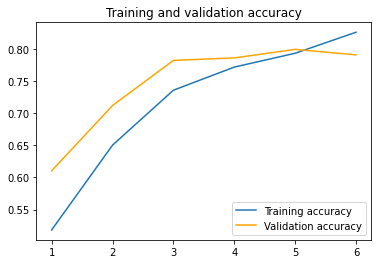

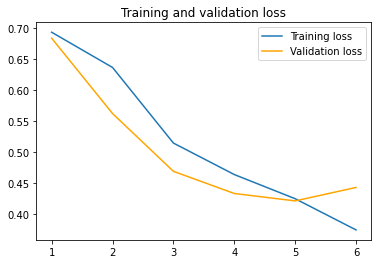

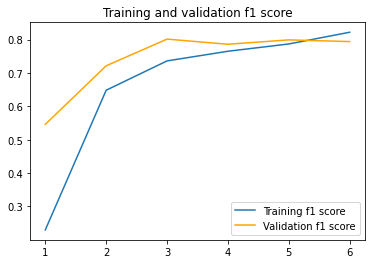

In [11]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, linestyle='solid', label='Training accuracy')
plt.plot(epochs, val_acc, linestyle='solid', color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, linestyle='solid', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, f1, linestyle='solid', label='Training f1 score')
plt.plot(epochs, val_f1, linestyle='solid', color='orange', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

# predict & submit

In [12]:
import numpy as np

predicted_model = model.predict([test_data, test_tfidf, test_tokenizer])

df_sample = pd.read_csv(PATH_SAMPLE_SUBMISSION, names=['id', 'pre'])
df_sub_model = pd.concat([df_sample['id'], pd.DataFrame(np.round(predicted_model), columns=['predicted']).astype(int)], axis=1)

df_sub_model.to_csv('submission_model.csv', index=False, header=False)

print('df_sub_model shape: {0}'.format(df_sub_model.shape))
df_sub_model.head()

df_sub_model shape: (10544, 2)


,id,predicted
0,10545,1
1,10546,1
2,10547,1
3,10548,0
4,10549,0


# ensemble

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
import lightgbm as lgb

train_data = np.concatenate([train_data, train_tfidf, train_tokenizer], axis=1)
test_data = np.concatenate([test_data, test_tfidf, test_tokenizer], axis=1)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

clf_svm = svm.SVC(kernel='rbf', C=1000, gamma=1e-3)
clf_lgb = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', learning_rate = 0.001, num_leaves = 100, random_state = 2021, n_jobs = -1, importance_type = 'gain', colsample_bytree = 0.5, reg_lambda = 5)

clf_svm.fit(train_data, Y)
clf_lgb.fit(train_data, Y)

predicted_svm = clf_svm.predict(test_data)
predicted_lgb = clf_lgb.predict(test_data)

df_sub_svm = pd.concat([df_sample['id'], pd.DataFrame(predicted_svm, columns=['predicted']).astype(int)], axis=1)
df_sub_lgb = pd.concat([df_sample['id'], pd.DataFrame(predicted_lgb, columns=['predicted']).astype(int)], axis=1)

df_sub = pd.concat([df_sample['id'], pd.DataFrame(np.round(df_sub_model['predicted'].values*0.25+df_sub_svm['predicted'].values*0.25+df_sub_lgb['predicted'].values*0.5)).astype(int)], axis=1)

df_sub.to_csv('submission.csv', index=False, header=False)
df_sub_svm.to_csv('submission_svm.csv', index=False, header=False)
df_sub_lgb.to_csv('submission_lgb.csv', index=False, header=False)